<a href="https://colab.research.google.com/github/vinicius-mattoso/churn_project/blob/main/ChurnModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho final da Sprint 3 do Curso Ciência de Dados e Analytics da PUC-Rio


Aluno: Vinicius Mattoso Reis da Silva

Ulitma Atualização : 21/04/2024

## Explicação da temática do problema

Esse trabalho tem por objetivo a contrução de um modelo de classificação do churn do cliente. Churn de cliente é o fato de um cliente da sua base cancela o serviço por algum motivo, fazer um modelo capaz de prever se o cliente vai abandonar a empresa permite uma melhor organização gerencial além de conseguir produzir ações mais certeiras e efetivas para evitar que esse cliente saia da empresa.

## Etapas do projeto

1) Análise Exploratória da base de dados:

  Essa análise pode ser encontrada nesse outro notebook

https://github.com/vinicius-mattoso/churn_project/blob/main/ChurnEDA.ipynb

2) Criação de modelos Base para classificação:

  Presente notebook

3) Otimização dos hyperparâmetros do modelo que possui uma melhor acertividade

  Presente notebook

### Carregar as libs necessárias

In [22]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada

from sklearn.neighbors import KNeighborsClassifier # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVM
from sklearn.dummy import DummyClassifier # algoritmo DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score # para a exibição da acurácia do modelo
from sklearn.metrics import f1_score




seed = 42

def set_random_seed(seed=42):
  np.random.seed(seed)
  random.seed(seed)
set_random_seed(seed=seed)

## Criação de uma classe para fazer todo o processamento inical dos dados


Essa classe será montada de acordo com as informações que foram obtidas no notebook de análise exploratória



In [2]:
class ChurnDataProcess ():
  def __init__(self,original_df):
    self.original_df = original_df
    self.modified_df = original_df.copy()

  def convert_total_charge_to_float(self):
    self.modified_df['TotalCharges'] = pd.to_numeric(self.modified_df['TotalCharges'], errors='coerce')

  def fill_nan_with_mean(self):
    self.modified_df['TotalCharges'].fillna((self.modified_df['TotalCharges'].mean()), inplace=True)

  def remove_id_column(self):
    self.modified_df.drop(columns='customerID', inplace=True)

  def use_only_select_columns(self):
    colunas_interessantes = ['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
                                'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod',
                                'MonthlyCharges', 'TotalCharges', 'Churn']
    self.modified_df = self.modified_df[colunas_interessantes]

  def encoding_data(self):
    le = LabelEncoder()
    self.modified_df_encoding = self.modified_df.copy()
    for column in self.modified_df_encoding.columns:
        if self.modified_df_encoding[column].dtype == 'object':
            self.modified_df_encoding[column] = le.fit_transform(self.modified_df_encoding[column])

  def return_data_preprocessed(self):

    return self.modified_df_encoding


## Início da criação dos modelos

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/vinicius-mattoso/churn_project/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


**Utilização da classe de pre processamento**

In [4]:
data = ChurnDataProcess(df)

**Etapas para obter o dataframe final para ser utilizado pelo modelo**

In [5]:
# converter o tipo de dado
data.convert_total_charge_to_float()
# utilizar apenas as colunas selecionadas
data.use_only_select_columns()
data.fill_nan_with_mean()
# Criação de um dataset utilizando o one hot encoder
data.encoding_data()
# Retonar o dataset pronto para ser consumido
dataframe_prepared = data.return_data_preprocessed()
#Print data
dataframe_prepared.head()

,SeniorCitizen,Partner,Dependents,tenure,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,1,0,2,0,0,0,1,2,29.85,29.85,0
1,0,0,0,34,2,0,2,0,1,0,3,56.95,1889.50,0
2,0,0,0,2,2,2,0,0,0,1,3,53.85,108.15,1
3,0,0,0,45,2,0,2,2,1,0,0,42.30,1840.75,0
4,0,0,0,2,0,0,0,0,0,1,2,70.70,151.65,1


In [6]:
dataframe_prepared.isnull().sum()

SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Separar dados de treino e dados de teste

In [7]:
# Assuming 'Churn' is the target variable
X = dataframe_prepared.drop(columns=['Churn'])  # All columns except 'Churn' are features
y = dataframe_prepared['Churn']  # 'Churn' column as target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)  # Splits the data

# Convert to array all the informations
X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values


In [8]:
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=seed) # faz o particionamento em 10 folds

### Criação de alguns modelos de classificação que utilizão a acurácia como métrica

CART: 0.726489 (0.020065)
NB: 0.744234 (0.020981)
dummy_classifier: 0.734465 (0.014147)
k_nearest_neighbors: 0.760205 (0.013797)
logistic_regression: 0.795347 (0.014064)
support_vector_machines: 0.734465 (0.014147)
random_forest: 0.791622 (0.015119)
gradient_boosting: 0.800144 (0.014742)
XGBoost: 0.780442 (0.011076)


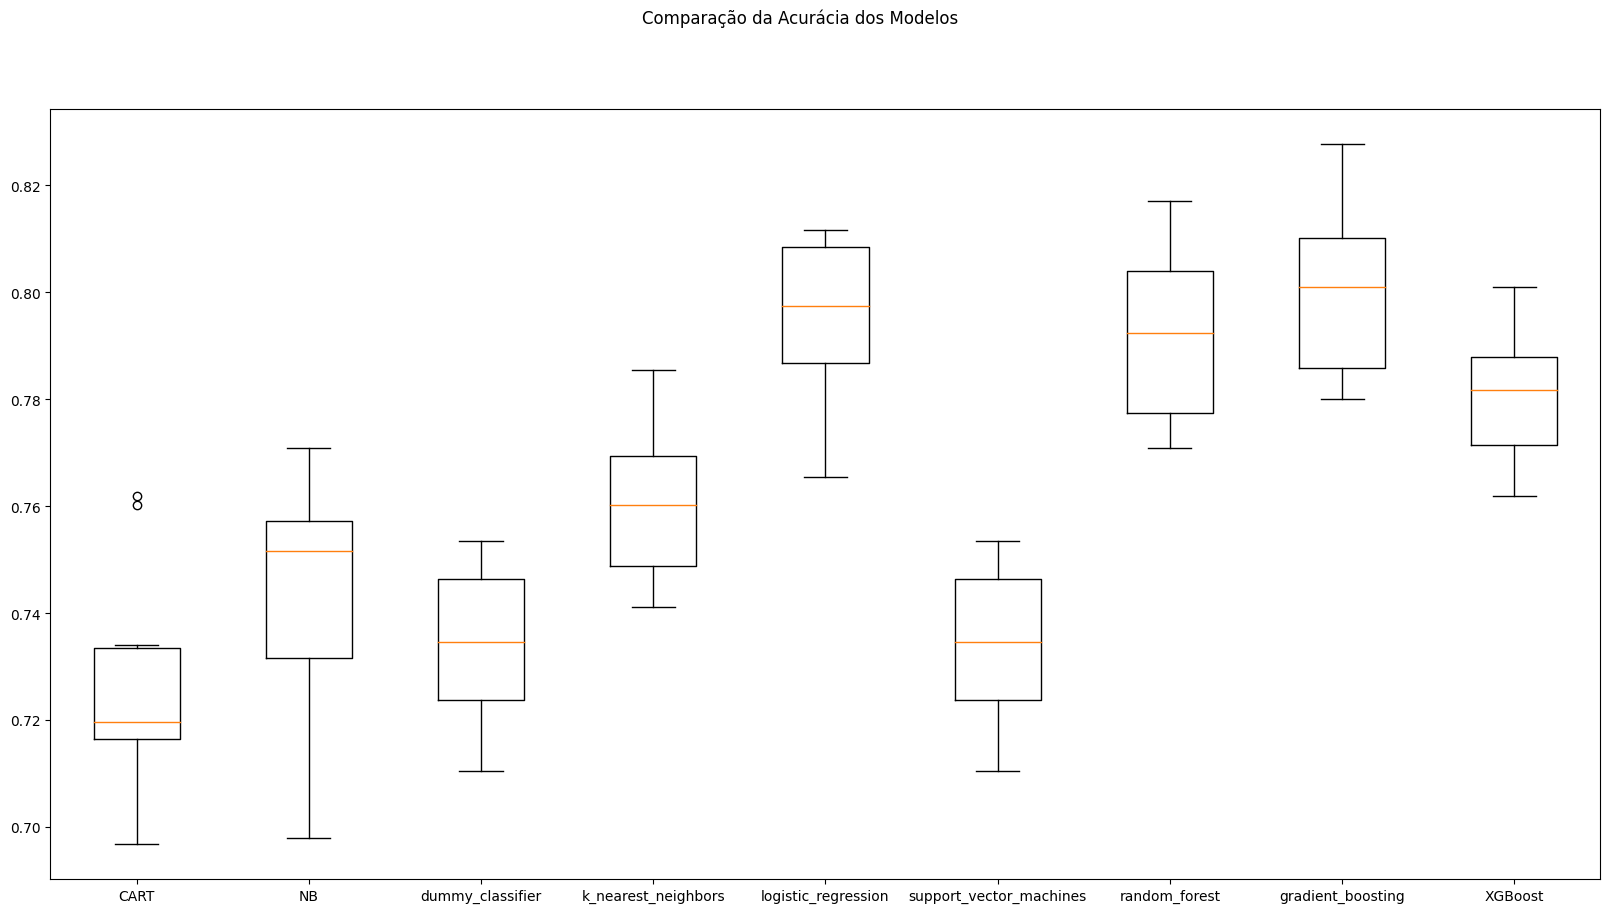

In [9]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(seed)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
models.append(('k_nearest_neighbors', KNeighborsClassifier()))
models.append(('logistic_regression', LogisticRegression(random_state=seed)))
models.append(('support_vector_machines', SVC(random_state=seed)))
models.append(('random_forest', RandomForestClassifier(random_state=seed)))
models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
models.append(('XGBoost', XGBClassifier(random_state=seed)))


# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação da Acurácia dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [16]:
# Criando um modelo com todo o conjunto de treino
model = GradientBoostingClassifier(random_state=seed)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)


### Matriz de Confusão para avaliar a construção do modelo

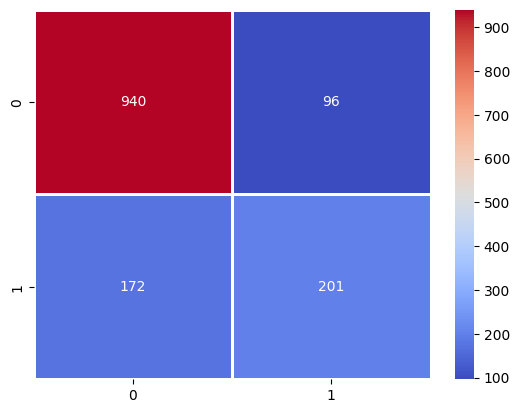

In [17]:
# Matriz de confusão
cf_matrix = confusion_matrix(y_test, predictions)
# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

### Criação de alguns modelos utilizando o f1 score como métrica de avaliação


Vamos avaliar os modelos utilizando a f1-score, pois é uma métrica mais recomendada para dados de base desbalanceadas, como o do problema em análise

CART: 0.490835 (0.034381)
NB: 0.601944 (0.025368)
dummy_classifier: 0.000000 (0.000000)
k_nearest_neighbors: 0.486853 (0.028599)
logistic_regression: 0.590169 (0.014748)
support_vector_machines: 0.000000 (0.000000)
random_forest: 0.546369 (0.027877)
gradient_boosting: 0.575940 (0.022045)
XGBoost: 0.554646 (0.017798)


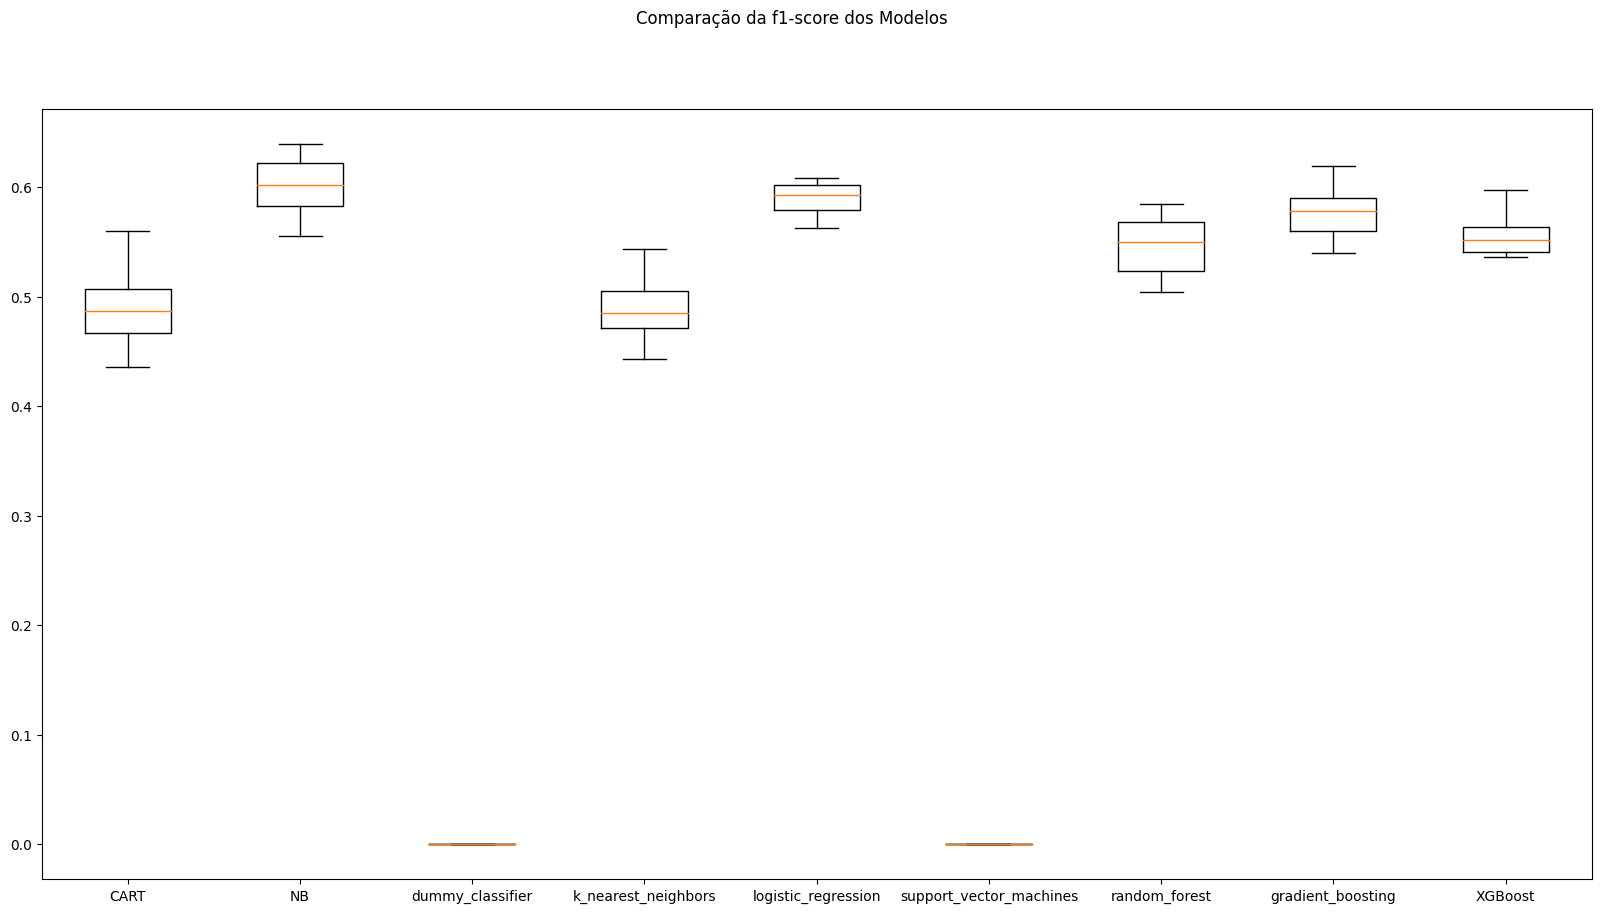

In [13]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(seed)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
models.append(('k_nearest_neighbors', KNeighborsClassifier()))
models.append(('logistic_regression', LogisticRegression(random_state=seed)))
models.append(('support_vector_machines', SVC(random_state=seed)))
models.append(('random_forest', RandomForestClassifier(random_state=seed)))
models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
models.append(('XGBoost', XGBClassifier(random_state=seed)))


# Avaliando um modelo por vez
for name, model in models:
  # cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()) # média e desvio padrão dos 10 resultados da validação cruzada
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(20, 10))
fig.suptitle('Comparação da f1-score dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [14]:
# Criando um modelo com todo o conjunto de treino
model = GaussianNB()
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)

### Criação da Matriz de Confusão para avaliar o modelo

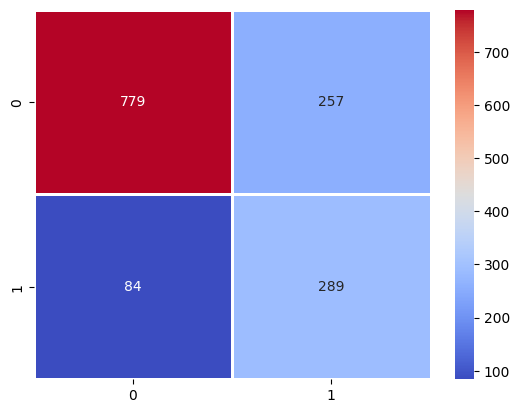

In [15]:
# Matriz de confusão
cf_matrix = confusion_matrix(y_test, predictions)
# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

**Conclusões a respeito do Modelo**

Em todos os modelos treinados tivemos uma resposta de acurácia superior a 0.7, o que a priori poderia indicar um resultado bom. No entanto quando analisados pela métrica de f1-score, podemos ver que os modelos support_vector_machines e dummy_classifier ficam bem longe do esperado.

A próxima etapa desse projeto vai ser pegar o modelo de GaussianNB e GradientBoosting para fazer um provesso de otimização com eles.

# OTIMIZAÇÃO DO MODELO GaussianNB

In [19]:
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 8.3 MB/s eta 0:00:00


In [20]:
def objective(trial, X_train, X_test, y_train, y_test):

    # Define hyperparameters to optimize
    var_smoothing = trial.suggest_loguniform('var_smoothing', 1e-10, 1e-5)

    # Model with hyperparameters
    model = GaussianNB(var_smoothing=var_smoothing)

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # # Calculate accuracy
    # metric = accuracy_score(y_test, y_pred)

    # Calculate F1-score
    metric = f1_score(y_test, y_pred, average='weighted')

    return metric

In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test), n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Metric:', trial.value)
print("Best hyperparameters:", trial.params)

[I 2024-04-22 18:44:45,628] A new study created in memory with name: no-name-04f4e6f4-ec29-4146-bc29-6e6e53b9cbca
[I 2024-04-22 18:44:45,667] Trial 0 finished with value: 0.7846831964494042 and parameters: {'var_smoothing': 8.288926259197554e-07}. Best is trial 0 with value: 0.7846831964494042.
[I 2024-04-22 18:44:45,683] Trial 1 finished with value: 0.7729964956035107 and parameters: {'var_smoothing': 9.81248828417195e-08}. Best is trial 0 with value: 0.7846831964494042.
[I 2024-04-22 18:44:45,698] Trial 2 finished with value: 0.7684640375415713 and parameters: {'var_smoothing': 1.6940078831232105e-09}. Best is trial 0 with value: 0.7846831964494042.
[I 2024-04-22 18:44:45,716] Trial 3 finished with value: 0.7691020601612597 and parameters: {'var_smoothing': 6.38618776618861e-10}. Best is trial 0 with value: 0.7846831964494042.
[I 2024-04-22 18:44:45,736] Trial 4 finished with value: 0.7663256853964096 and parameters: {'var_smoothing': 1.1099531489942886e-08}. Best is trial 0 with val

Number of finished trials: 100
Best trial:
Metric: 0.786333961385389
Best hyperparameters: {'var_smoothing': 7.637807960354439e-07}


In [25]:
optuna.visualization.plot_optimization_history(study)

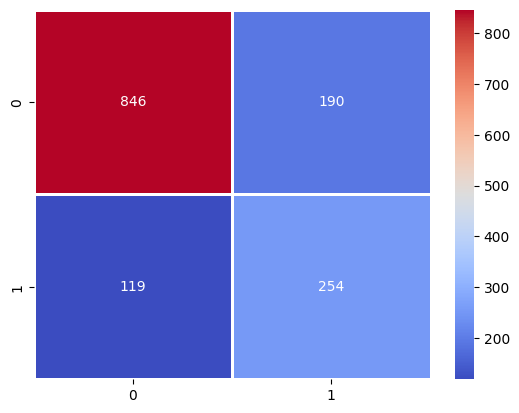

In [27]:
# Criando um modelo com todo o conjunto de treino
model = GaussianNB(var_smoothing= 7.637807960354439e-07)
model.fit(X_train, y_train)

# Fazendo as predições com o conjunto de teste
predictions = model.predict(X_test)
# Matriz de confusão
cf_matrix = confusion_matrix(y_test, predictions)
# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()

# OTIMIZAÇÃO DO MODELO GaussianNB

In [28]:
def objective(trial, X_train, X_test, y_train, y_test,seed):

    # Define hyperparameters to optimize
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 1, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)


    # Model with hyperparameters
    model = GradientBoostingClassifier(
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=seed
    )

    # Train the model
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)

    # # Calculate accuracy
    # metric = accuracy_score(y_test, y_pred)

    # Calculate F1-score
    metric = f1_score(y_test, y_pred, average='weighted')

    return metric

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train, X_test, y_train, y_test, seed), n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('Metric:', trial.value)
print("Best hyperparameters:", trial.params)

[I 2024-04-22 18:52:22,260] A new study created in memory with name: no-name-8b70074b-8256-4338-9982-de53535d1fc6
[I 2024-04-22 18:52:43,111] Trial 0 finished with value: 0.774871430838638 and parameters: {'learning_rate': 0.03069545240644376, 'n_estimators': 233, 'max_depth': 29, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.774871430838638.
[I 2024-04-22 18:52:50,962] Trial 1 finished with value: 0.7869680093414191 and parameters: {'learning_rate': 0.08299625695625935, 'n_estimators': 353, 'max_depth': 5, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7869680093414191.
[I 2024-04-22 18:53:08,504] Trial 2 finished with value: 0.7646681210946853 and parameters: {'learning_rate': 0.09470694471043856, 'n_estimators': 348, 'max_depth': 18, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.7869680093414191.
[I 2024-04-22 18:53:14,747] Trial 3 finished with value: 0.7835810203710186 and parameters: 

Number of finished trials: 100
Best trial:
Metric: 0.8069653457888014
Best hyperparameters: {'learning_rate': 0.047913404319099344, 'n_estimators': 89, 'max_depth': 4, 'min_samples_split': 8, 'min_samples_leaf': 20}


In [30]:
optuna.visualization.plot_optimization_history(study)

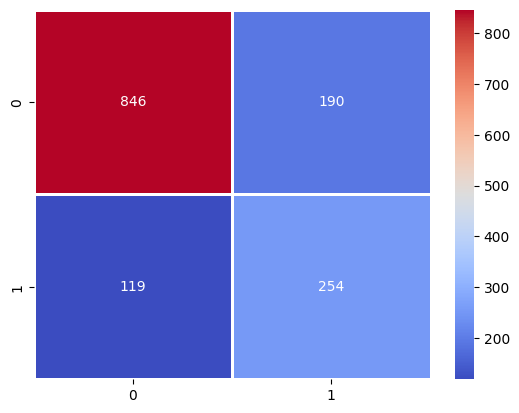

In [33]:
model = GradientBoostingClassifier(
        learning_rate=trial.params['learning_rate'],
        n_estimators=trial.params['n_estimators'],
        max_depth=trial.params['max_depth'],
        min_samples_split=trial.params['min_samples_split'],
        min_samples_leaf=trial.params['min_samples_leaf'],
        random_state=seed
    )

# Train the model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Matriz de confusão
cf_matrix = confusion_matrix(y_test, predictions)
# Criando o heatmap
sns.heatmap(cf_matrix, cmap='coolwarm', annot=True, linewidth=1, fmt='d')
plt.show()